In [ ]:
import warnings 
warnings.filterwarnings('ignore')

from modules.Utils.utils import loadFromDB,strategyTester

import pandas as pd
import numpy as np
import ccxt
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count
from time import sleep
from random import randint

In [ ]:
exchange = ccxt.kucoin()
markets = exchange.load_markets()

def get_ohlcv(symbol, tf='1d'):
    flag = False
    while flag is False:
        try:
            sleep(randint(1,4)/10)
            df = pd.DataFrame(exchange.fetch_ohlcv(symbol, tf, limit=5000))
            df = df.rename(columns={0: 'timestamp', 1: 'open', 2: 'high', 3: 'low', 4: 'close', 5: 'volume'})
            df = df.set_index(df['timestamp'])
            df.index = pd.to_datetime(df.index, unit='ms')
            del df['timestamp']
            df.dropna(inplace=True)
            flag = True
            return symbol,df
        except Exception as e:
            sleep(randint(1,4))
            flag = False

In [ ]:
with ProcessPoolExecutor(max_workers=8) as executor:
    processes = [executor.submit(get_ohlcv, symb) for symb in filter(lambda symbol: symbol.split("/")[-1]=="USDT",exchange.symbols)]

full_df = pd.DataFrame()

for task in as_completed(processes):
    symb, df = task.result()
    if len(df)>=500 and df.volume.mean()>=5000:
        print(f'{symb}')
        full_df[symb]=df.close.iloc[-501:]
        
cumret = np.log(full_df).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)
cumret

<AxesSubplot: xlabel='return', ylabel='std'>

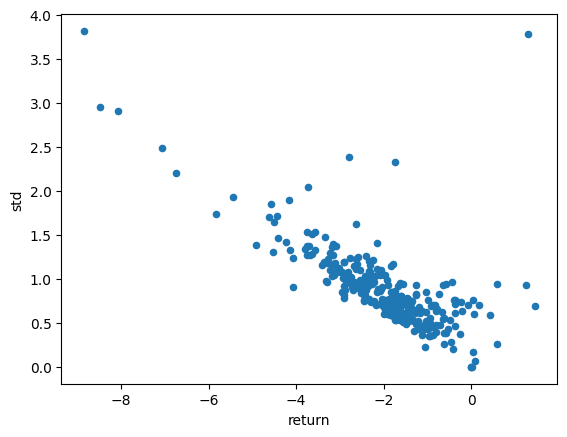

In [26]:

pre_select_obj = {}
for col in list(cumret.columns.values):
    pre_select_obj[col] = {
        "return": cumret[col].iloc[-1] - cumret[col].iloc[0],
        # "return": cumret[col].diff().mean(),
        "std": cumret[col].std()
    }

df_pre_select = pd.DataFrame.from_dict(pre_select_obj, orient='index')
df_pre_select.plot.scatter(x='return', y='std')

In [19]:
import yfinance as yf

for index,row in pd.read_csv('https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv',
            names=['ticker']).iterrows():

    msft = yf.Ticker(row['ticker'])
    # get historical market data
    hist = msft.history(period="max")
    print(row['ticker'])

DDD
MMM
Got error from yahoo api for ticker WBAI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- WBAI: No data found for this date range, symbol may be delisted
WBAI
Got error from yahoo api for ticker WUBA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- WUBA: No data found for this date range, symbol may be delisted
WUBA
EGHT
Got error from yahoo api for ticker AHC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AHC: No data found for this date range, symbol may be delisted
AHC


KeyboardInterrupt: 

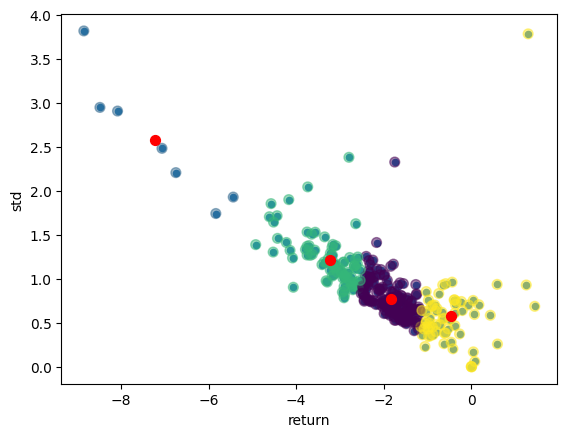

In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df_pre_select = pd.DataFrame.from_dict(pre_select_obj, orient='index')
df_pre_select.plot.scatter(x='return', y='std')
  
kmeans = KMeans(n_clusters=4).fit(df_pre_select)
centroids = kmeans.cluster_centers_
# print(centroids)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_pre_select.index.values
cluster_map['cluster'] = kmeans.labels_

plt.scatter(df_pre_select['return'], df_pre_select['std'], s=50, c=kmeans.labels_.astype(int), alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [ ]:
for symb in ['AAVE','ADA','ALGO','AVAX','AXS','BTC','DOT','EGLD','ETH','KDA','LINK','MATIC','NEAR','SOL','UNI','XRP']:
    df =loadFromDB(symb,'1d')#.iloc[-300:]
    df['Max_pos_var'] = df.apply(lambda row: (row['High']-row['Open'])/row['Open'],axis=1)
    df['Close_pos_var'] = df.apply(lambda row: (row['Close']-row['Open'])/row['Open'],axis=1)


    TP = df['Max_pos_var'].quantile(0.65)
    equity = 1000
    fees = 0.001
    df['Hits'] = df.apply(lambda row:
                        (row['Open']*(1+TP)-row['Open'])/row['Open'] 
                        if row['High']>=row['Open']*(1+TP) else
                        (row['Close']-row['Open'])/row['Open']
                          ,axis=1)
    
    df['Hits'] = df['Hits']-2*fees
    df['Equity'] = np.nan
    for i in df.index:
        equity = (1+df['Hits'][i])*equity
        df['Equity'][i]=equity
    #df['Equity'].plot()
    #equities.append(equity)
    print(f'{symb} Final balance {equity}')

In [ ]:
result_df = pd.DataFrame()
for q in range(10,80,5):
  equities = []
  for symb in ['AAVE','ADA','ALGO','AVAX','AXS','BTC','DOT','EGLD','ETH','KDA','LINK','MATIC','NEAR','SOL','UNI','XRP']:#SYMBOL= 'LINK'
    df =loadFromDB(symb,'1d')
    df['Max_pos_var'] = df.apply(lambda row: (row['High']-row['Open'])/row['Open'],axis=1)
    df['Close_pos_var'] = df.apply(lambda row: (row['Close']-row['Open'])/row['Open'],axis=1)


    TP = df['Max_pos_var'].quantile(q/100)
    equity = 1000
    fees = 0.001
    df['Hits'] = df.apply(lambda row:
                        (row['Open']*(1+TP)-row['Open'])/row['Open'] 
                        if row['High']>=row['Open']*(1+TP) else
                        (row['Close']-row['Open'])/row['Open']
                          ,axis=1)
    
    #df['Hits'] = df['Hits']-2*fees
    df['Equity'] = np.nan
    for i in df.index:
        equity = (1+df['Hits'][i])*equity
        df['Equity'][i]=equity
    #df['Equity'].plot()
    equities.append(equity)
    #print(f'{symb} Final balance {equity}')
  result_df = result_df.append({'avg_equity':np.mean(equities),
                    'std_equity' : np.std(equities),
                    'quantile':q/100},
                               ignore_index=True)  
  
  print(f'Final balance : Avg {np.mean(equities)} - Std {np.std(equities)} - Q {q/100}')
result_df.sort_values(by=['std_equity','avg_equity',], ascending=[False, True])

In [ ]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'5m')

df['10_period_return'] = df.Close/df.Close.shift(10)-1
df['5_period_return'] = df.Close/df.Close.shift(5)-1
df.dropna(inplace=True)
print(df.shape)
df.head()

In [ ]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row['5_period_return'] < -0.015 and row['10_period_return']>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
     return False

strategyTester(df,buyCondition,sellCondition,equity=1000, stop_loss= True, take_profit= True, tp=0.01, sl=0.005)

# OLR Regressor

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant 

SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1h').iloc[-6000:]
df.head()

In [ ]:
def computeLaggingLinearRegression(df:pd.DataFrame, col:str="Close",window:int=15,)->pd.DataFrame:
    """Compute a lagging moving regression on a column with a window.

    Args:
        df (pd.DataFrame): The dataframe containing features.
        col (str, optional): The column we apply Linear regression on. Defaults to "Close.
        window (int, optional): The window we apply linear regression on. Defaults to 15.

    Returns:
        pd.DataFrame: The entry DataFrame we another column called B_MLR_coefs
    """  
    def computeLinearRegression(to_predict)->float:
        """Compute simple linear regression between 2 vectors x and y

        Args:
            to_predict (np.array): x vector

        Returns:
            float: The coefficient a corresponding to the linear regression y=ax+b.
        """
        model = OLS(to_predict,add_constant(tuple(range(len(to_predict))))).fit()
        return model.predict()[-1]
    
    df['LSMA'] = np.nan
    df['LSMA'].iloc[window:] = [computeL35inearRegression(df[col].values[i-window:i]) for i in range(window,len(df))] 

    return df.dropna()

In [ ]:
df = computeLaggingLinearRegression(df)
df.head()

In [ ]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Close<row.LSMA else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Close>row.LSMA else False

SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1h')
df = computeLaggingLinearRegression(df,'Close',95)

result = pd.DataFrame()
trade_dict = {}
fees = 0.001
equity = 1000
opened = False

for index, row in df.iterrows():
    if not opened and buyCondition(row):
        trade_dict['buy_price'] = row.Close
        trade_dict['buy_date'] = index
        opened = True
    elif opened and sellCondition(row):
        trade_dict['sell_price'] = row.Close
        trade_dict['sell_date'] = index
        equity = (1+(trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])*equity
        trade_dict['equity'] = equity
        trade_dict['comment'] = "SELL"
        result = result.append(trade_dict,ignore_index=True)
        opened = False
        trade_dict = {}
        
print(f'Final equity : {equity:.0f} USDT, BH Return : {(100*(df.iloc[0].Open-df.iloc[-1].Close)/df.iloc[0].Open)-100:.0f} %')     

In [ ]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Close<row.LSMA else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Close>row.LSMA else False

for i in range(5,400,10): #W=95
    SYMBOL= 'BTC'
    df =loadFromDB(SYMBOL,'1h').iloc[-5000:]
    df = computeLaggingLinearRegression(df,'Close',i)

    result = pd.DataFrame()
    trade_dict = {}
    fees = 0.001
    equity = 1000
    opened = False

    for index, row in df.iterrows():
        if not opened and buyCondition(row):
            trade_dict['buy_price'] = row.Close
            trade_dict['buy_date'] = index
            opened = True
        elif opened and sellCondition(row):
            trade_dict['sell_price'] = row.Close
            trade_dict['sell_date'] = index
            equity = (1+(trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])*equity
            trade_dict['equity'] = equity
            trade_dict['comment'] = "SELL"
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
    result['time_diff'] = result.apply(lambda x: x.sell_date-x.buy_date, axis=1)
    print(f'W {i} Final equity : {equity:.0f} USDT, BH Return : {(100*(df.iloc[0].Open-df.iloc[-1].Close)/df.iloc[0].Open)-100:.0f} %')     

In [ ]:
df.Close.plot()

In [ ]:
result.equity.plot()